In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.colors as mcolors
import numpy as np
import sys
import os

# --- 1. 设置字体和文件路径 (Kaggle路径) ---
# 定义文件所在的目录
input_dir = '/kaggle/input/nssfc-2025/'

# 定义字体文件路径
font_path_chinese = os.path.join(input_dir, 'simkai.ttf')
font_path_english = os.path.join(input_dir, 'times.ttf')

# 检查字体文件是否存在
if not os.path.exists(font_path_chinese):
    print(f"警告: 字体文件 '{font_path_chinese}' 未找到。中文可能无法正确显示。")
    ch_font = fm.FontProperties()
else:
    ch_font = fm.FontProperties(fname=font_path_chinese)
    fm.fontManager.addfont(font_path_chinese)

if not os.path.exists(font_path_english):
    print(f"警告: 字体文件 '{font_path_english}' 未找到。非中文字符可能无法使用指定字体。")
    en_font = fm.FontProperties()
else:
    en_font = fm.FontProperties(fname=font_path_english)
    fm.fontManager.addfont(font_path_english)

plt.rcParams['axes.unicode_minus'] = False 

# --- 2. 加载和准备数据 (Kaggle路径) ---
data_file = os.path.join(input_dir, 'nssfc-fenci.csv')
try:
    df = pd.read_csv(data_file)
except FileNotFoundError:
    print(f"错误: 数据文件 '{data_file}' 未找到。请确保文件位于指定的Kaggle输入目录中。")
    sys.exit()
except Exception as e:
    print(f"读取CSV文件时出错: {e}")
    sys.exit()

df['课题名称分词'] = df['课题名称分词'].fillna('')

# --- 3. 将每个学科门类的项目合并为一个文档 ---
print("正在按'学科门类'聚合文本...")
if '涉及学科' not in df.columns or '课题名称分词' not in df.columns:
    print("错误: CSV文件缺少 '涉及学科' 或 '课题名称分词' 列。")
    sys.exit()
    
corpus = df.groupby('涉及学科')['课题名称分词'].apply(' '.join)

target_disciplines = ['管理学', '应用经济学', '理论经济学','信息资源管理与文献学','新闻学与传播学']
if not all(d in corpus.index for d in target_disciplines):
    print(f"错误: 部分目标学科未在数据中找到。")
    print(f"可用的学科门类有: {corpus.index.tolist()}")
    sys.exit()

print(f"数据聚合完成。共找到 {len(corpus)} 个学科门类文档。")

# --- 4. 计算 TF-IDF (微调：添加停用词) ---
print("正在计算 TF-IDF 矩阵...")

# 微调：定义人文社科领域的常见停用词，根据您的要求加入“研究”
# 您可以根据需要向这个列表中添加更多词


research_meta_stopwords = [
    '影响', '体系', '视域', '机理', '效应', '构建', '建构', '理论', '实践', 
    '对策', '视角', '背景', '基于', '模式', '应用', '问题', '评估', '测度', 
    '关系', '形成', '重构', '逻辑', '形态', '系统', '模型', '演化', '演变', 
    '经验', '资料', '史料', '要素', '研究', '机制', '路径', '及其'
]

# 2. 高度泛化的背景词
generalized_context_stopwords = [
    '中国', '社会', '我国', '国家', '时代', '当代', '时期', '历史', 
    '世纪', '1949', '近代'
]

# 3. 抽象的过程、目标与修饰词
abstract_process_stopwords = [
    '策略', '提升', '优化', '整理', '驱动', '赋能', '建设', '实现', '应对', 
    '促进', '困境', '动态', '识别', '效能', '交融'
]

my_stop_words = research_meta_stopwords+generalized_context_stopwords+abstract_process_stopwords

print(f"将使用以下自定义停用词: {my_stop_words}")

vectorizer = TfidfVectorizer(
    max_features=1000, 
    stop_words=my_stop_words
) 
tfidf_matrix = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names_out()
print("TF-IDF 计算完成。")

# --- 5. 提取关键词的辅助函数 (无变化) ---
def get_top_keywords(discipline_name, corpus, tfidf_matrix, feature_names, top_n=20):
    """
    从TF-IDF矩阵中提取指定学科的前N个关键词。
    """
    try:
        idx = corpus.index.get_loc(discipline_name)
    except KeyError:
        print(f"未找到学科: {discipline_name}")
        return pd.DataFrame()
        
    scores = tfidf_matrix[idx].toarray().flatten()
    df_tfidf = pd.DataFrame({'word': feature_names, 'tfidf': scores})
    df_top = df_tfidf.sort_values(by='tfidf', ascending=False).head(top_n)
    return df_top

def plot_top_keywords_gradient(df_top, title_text, filename, ch_font, en_font):
    """
    绘制横向柱状图（渐变色），先保存后显示，避免保存成白图。
    """
    if df_top.empty:
        print(f"没有数据可用于绘制: {title_text}")
        return

    # 排序
    df_sorted = df_top.sort_values(by='tfidf', ascending=True)

    # 渐变色
    cmap = plt.cm.plasma
    norm = mcolors.Normalize(vmin=df_sorted['tfidf'].min(), vmax=df_sorted['tfidf'].max())
    colors = cmap(norm(df_sorted['tfidf'].values))

    # ✅ 显式 fig/ax
    fig, ax = plt.subplots(figsize=(14, 10))

    bars = ax.barh(df_sorted['word'], df_sorted['tfidf'], color=colors)

    ax.set_title(title_text, fontproperties=ch_font, fontsize=20, pad=25)
    ax.set_xlabel('TF-IDF Score', fontproperties=ch_font, fontsize=14)
    ax.set_ylabel('关键词', fontproperties=ch_font, fontsize=14)

    ax.tick_params(axis='y', labelsize=12)
    plt.setp(ax.get_yticklabels(), fontproperties=ch_font)
    ax.tick_params(axis='x', labelsize=12)
    plt.setp(ax.get_xticklabels(), fontproperties=en_font)

    ax.grid(axis='x', linestyle='--', alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # ✅ 用 fig.colorbar 绑定当前 fig/ax
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', pad=0.03, aspect=30)
    cbar.set_label('TF-IDF Score (强度)', fontproperties=ch_font, size=12)
    plt.setp(cbar.ax.get_yticklabels(), fontproperties=en_font)

    fig.tight_layout()

    # ✅ 先保存，再显示；并使用 fig.savefig（避免状态被 show 清空）
    try:
        fig.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"图表已成功保存为: {filename} (位于 /kaggle/working/ 目录)")
    except Exception as e:
        print(f"保存图表 '{filename}' 时出错: {e}")

    # 再显示
    try:
        print(f"正在显示图表: {title_text}")
        plt.show()
    except Exception as e:
        print(f"显示图表时出错: {e} (在非notebook环境中可能发生)")

    plt.close(fig)  # ✅ 关闭具体 fig




正在按'学科门类'聚合文本...
数据聚合完成。共找到 25 个学科门类文档。
正在计算 TF-IDF 矩阵...
将使用以下自定义停用词: ['影响', '体系', '视域', '机理', '效应', '构建', '建构', '理论', '实践', '对策', '视角', '背景', '基于', '模式', '应用', '问题', '评估', '测度', '关系', '形成', '重构', '逻辑', '形态', '系统', '模型', '演化', '演变', '经验', '资料', '史料', '要素', '研究', '机制', '路径', '及其', '中国', '社会', '我国', '国家', '时代', '当代', '时期', '历史', '世纪', '1949', '近代', '策略', '提升', '优化', '整理', '驱动', '赋能', '建设', '实现', '应对', '促进', '困境', '动态', '识别', '效能', '交融']
TF-IDF 计算完成。


正在生成 '管理学' 关键词图表...
图表已成功保存为: top_manage.png (位于 /kaggle/working/ 目录)
正在显示图表: 管理学 TF-IDF 关键词 Top 20


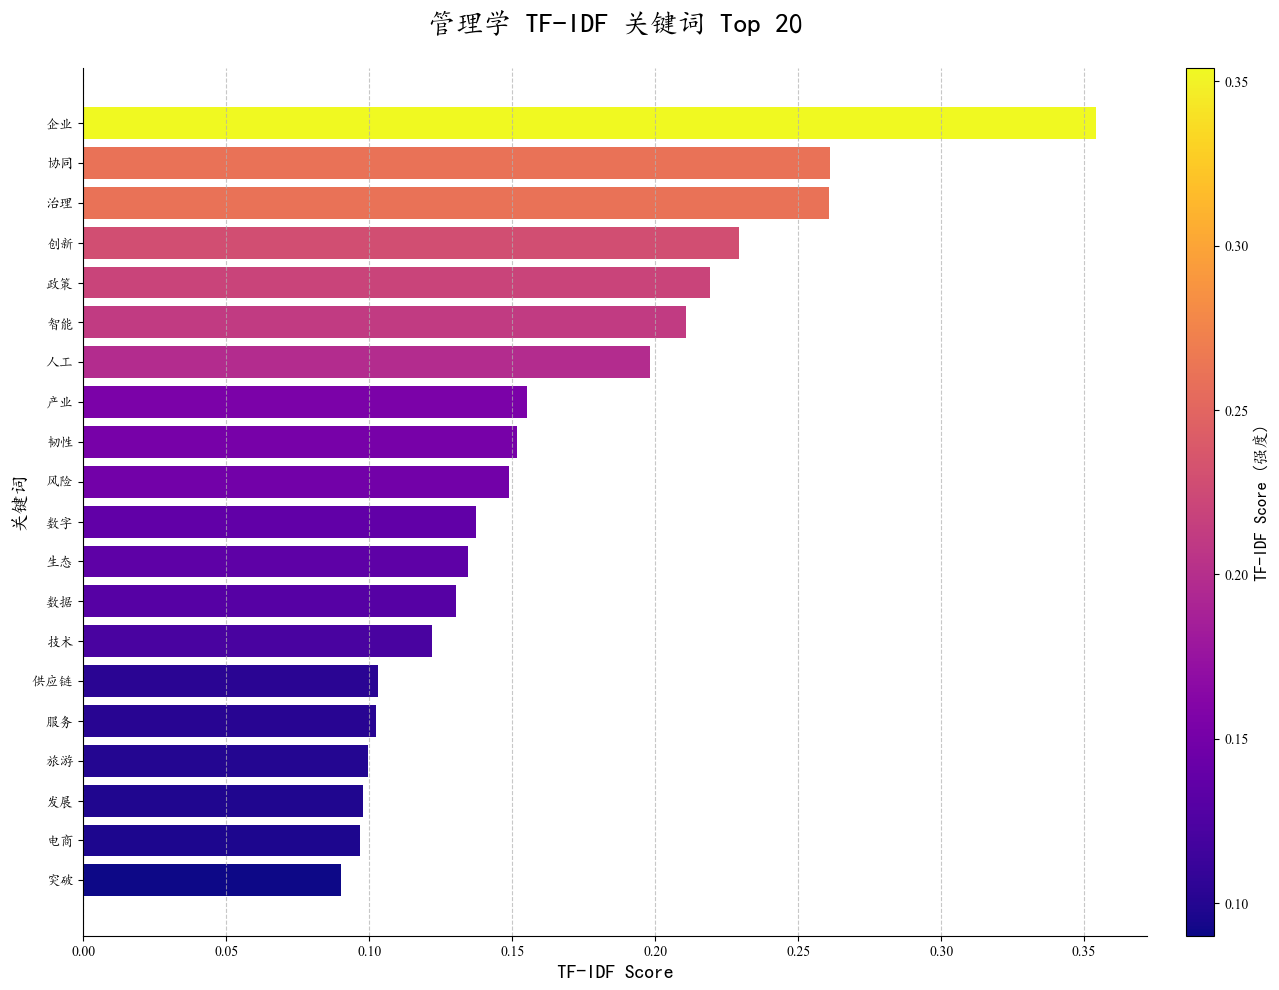

    word     tfidf
87    企业  0.354141
242   协同  0.260939
614   治理  0.260852
205   创新  0.229150
507   政策  0.219167
562   智能  0.210765
73    人工  0.198042
66    产业  0.155017
976   韧性  0.151771
987   风险  0.148799
515   数字  0.137125
672   生态  0.134590
518   数据  0.130214
469   技术  0.121888
111  供应链  0.103136
567   服务  0.102311
551   旅游  0.099549
260   发展  0.097701
681   电商  0.096595
724   突破  0.090068
正在生成 '应用经济学' 关键词图表...
图表已成功保存为: top_yingyong.png (位于 /kaggle/working/ 目录)
正在显示图表: 应用经济学 TF-IDF 关键词 Top 20


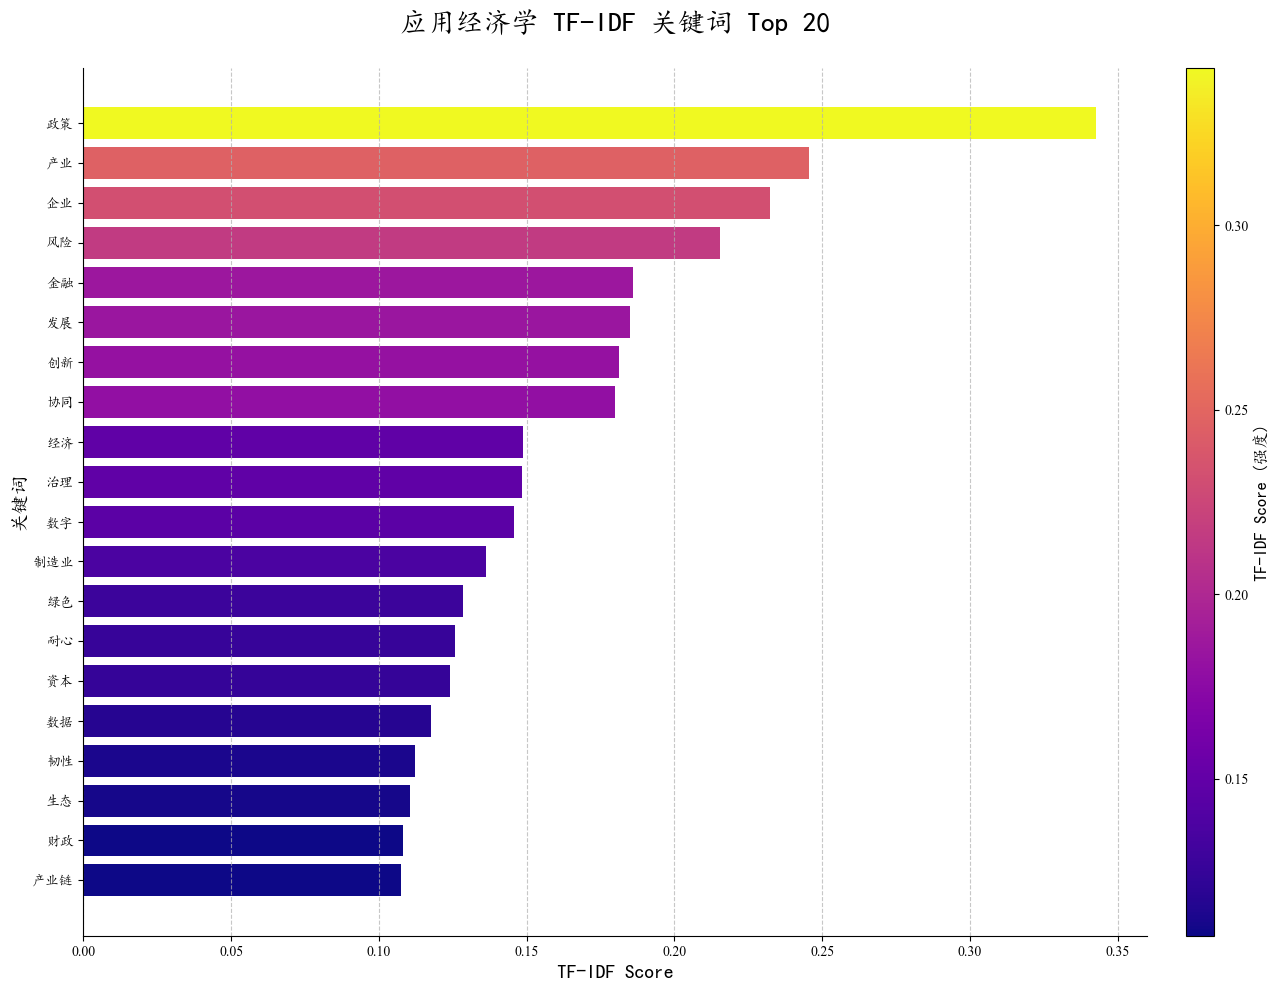

    word     tfidf
507   政策  0.342694
66    产业  0.245691
87    企业  0.232417
987   风险  0.215328
938   金融  0.185944
260   发展  0.184994
205   创新  0.181149
242   协同  0.179813
749   经济  0.148738
614   治理  0.148445
515   数字  0.145822
215  制造业  0.136110
760   绿色  0.128503
777   耐心  0.125759
880   资本  0.124072
518   数据  0.117504
976   韧性  0.112332
672   生态  0.110411
874   财政  0.108151
67   产业链  0.107509
正在生成 '理论经济学' 关键词图表...
图表已成功保存为: top_lilun.png (位于 /kaggle/working/ 目录)
正在显示图表: 理论经济学 TF-IDF 关键词 Top 20


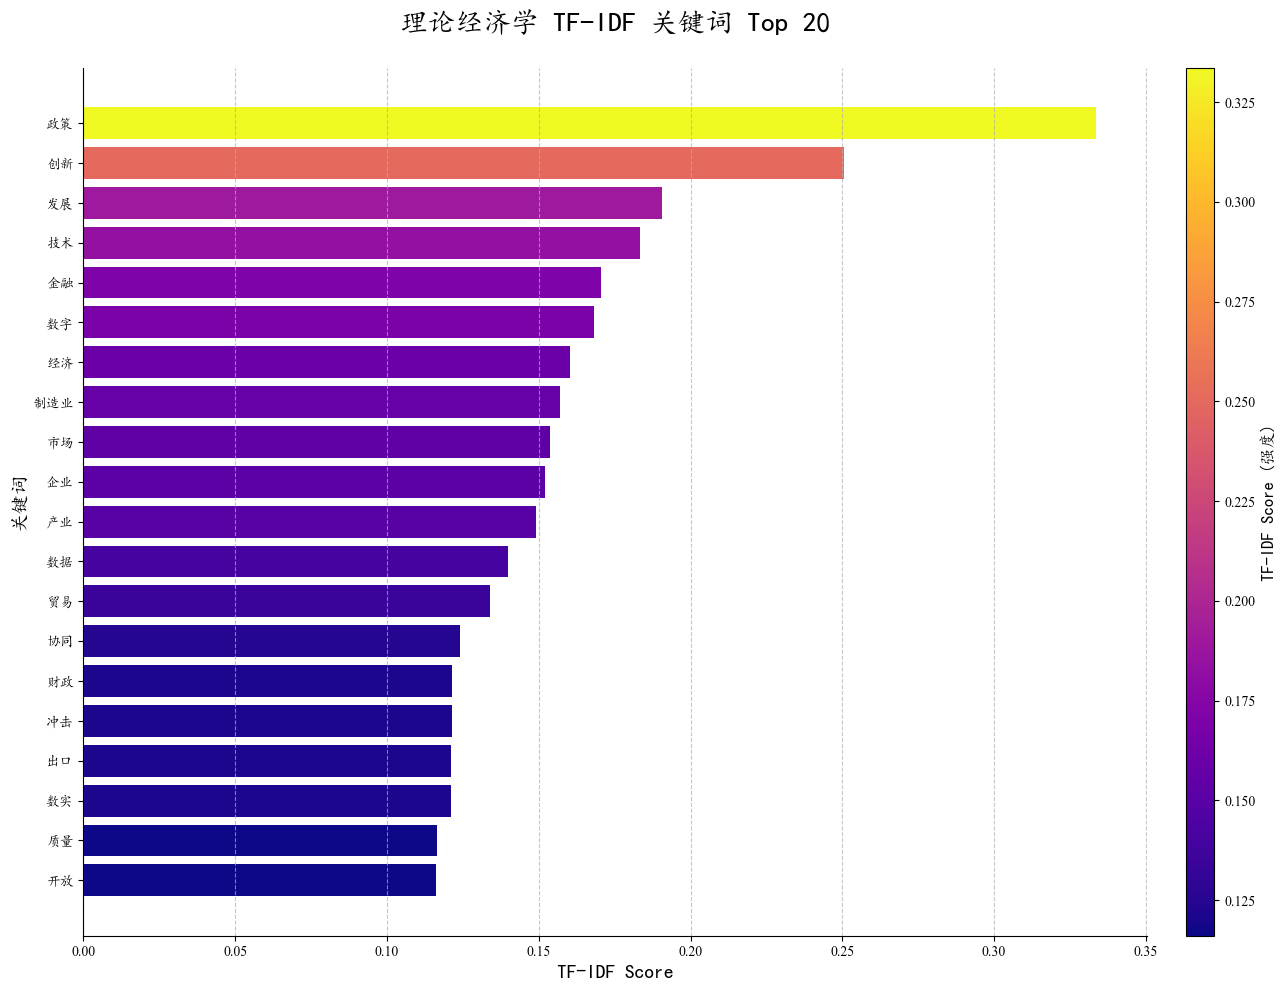

    word     tfidf
507   政策  0.333603
205   创新  0.250652
260   发展  0.190630
469   技术  0.183323
938   金融  0.170452
515   数字  0.168046
749   经济  0.160408
215  制造业  0.156854
404   市场  0.153588
87    企业  0.152182
66    产业  0.149215
518   数据  0.139889
878   贸易  0.133927
242   协同  0.123934
874   财政  0.121397
182   冲击  0.121397
187   出口  0.121067
517   数实  0.121067
877   质量  0.116374
421   开放  0.116057
正在生成 '信息资源管理与文献学' 关键词图表...
图表已成功保存为: top_xinxi.png (位于 /kaggle/working/ 目录)
正在显示图表: 信息资源管理与文献学 TF-IDF 关键词 Top 20


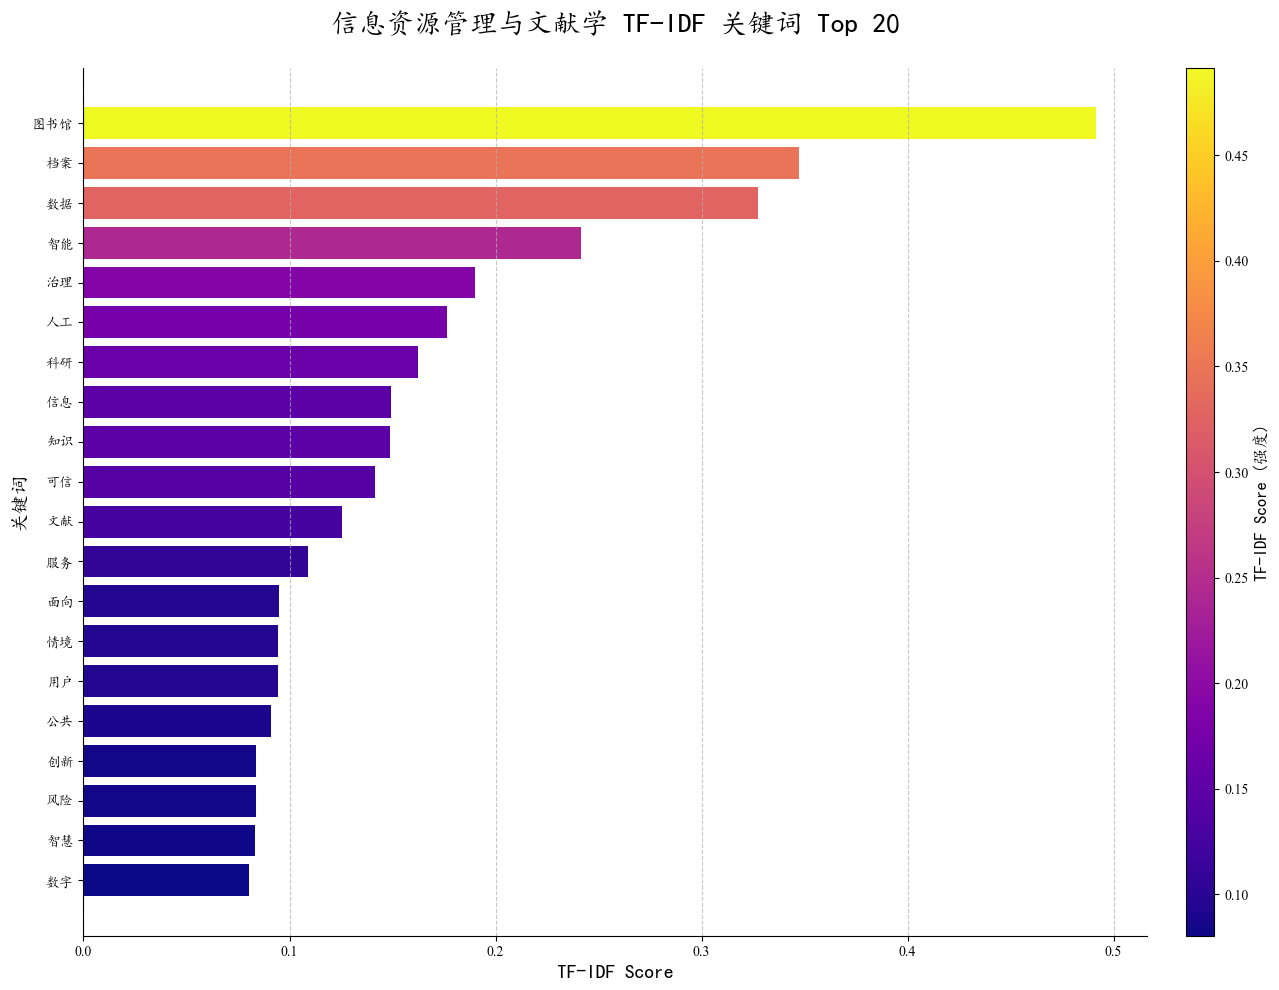

    word     tfidf
304  图书馆  0.491488
588   档案  0.347265
518   数据  0.327407
562   智能  0.241347
614   治理  0.190264
73    人工  0.176607
713   科研  0.162294
123   信息  0.149395
693   知识  0.148721
275   可信  0.141677
533   文献  0.125709
567   服务  0.109136
973   面向  0.094709
440   情境  0.094452
679   用户  0.094452
145   公共  0.091023
205   创新  0.083806
987   风险  0.083806
561   智慧  0.083435
515   数字  0.080449
正在生成 '新闻学与传播学' 关键词图表...
图表已成功保存为: top_xinwen.png (位于 /kaggle/working/ 目录)
正在显示图表: 新闻学与传播学 TF-IDF 关键词 Top 20


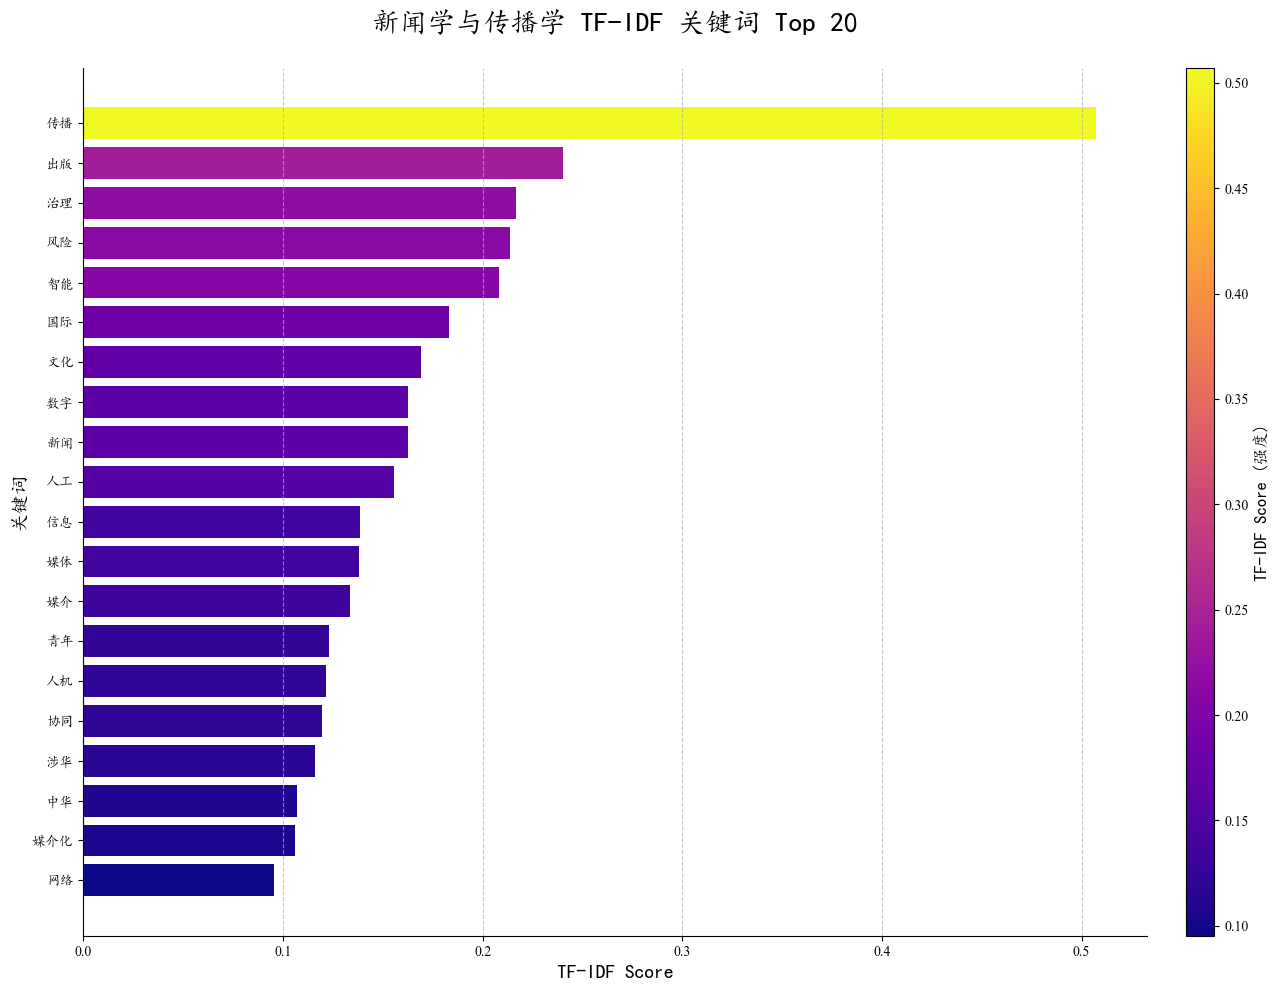

    word     tfidf
92    传播  0.507229
190   出版  0.240292
614   治理  0.216888
987   风险  0.213624
562   智能  0.208321
302   国际  0.183084
526   文化  0.169076
515   数字  0.162751
543   新闻  0.162522
73    人工  0.155699
123   信息  0.138477
358   媒体  0.137951
356   媒介  0.133682
967   青年  0.122781
77    人机  0.121529
242   协同  0.119709
635   涉华  0.116080
33    中华  0.106812
357  媒介化  0.105745
763   网络  0.095262
所有任务完成。


In [2]:
# --- 7. 执行提取和绘图 ---
try:
    print("正在生成 '管理学' 关键词图表...")
    top_manage = get_top_keywords('管理学', corpus, tfidf_matrix, feature_names, top_n=20)
    plot_top_keywords_gradient(top_manage, 
                              '管理学 TF-IDF 关键词 Top 20', 
                              'top_manage.png', 
                              ch_font, 
                              en_font)
    print(top_manage)
    
    print("正在生成 '应用经济学' 关键词图表...")
    top_yingyong = get_top_keywords('应用经济学', corpus, tfidf_matrix, feature_names, top_n=20)
    plot_top_keywords_gradient(top_yingyong, 
                              '应用经济学 TF-IDF 关键词 Top 20', 
                              'top_yingyong.png', 
                              ch_font, 
                              en_font)
    
    print(top_yingyong)

    print("正在生成 '理论经济学' 关键词图表...")
    top_lilun = get_top_keywords('理论经济学', corpus, tfidf_matrix, feature_names, top_n=20)
    plot_top_keywords_gradient(top_lilun, 
                              '理论经济学 TF-IDF 关键词 Top 20', 
                              'top_lilun.png', 
                              ch_font, 
                              en_font)
    print(top_lilun)

    print("正在生成 '信息资源管理与文献学' 关键词图表...")
    top_xinxi = get_top_keywords('信息资源管理与文献学', corpus, tfidf_matrix, feature_names, top_n=20)
    plot_top_keywords_gradient(top_xinxi, 
                              '信息资源管理与文献学 TF-IDF 关键词 Top 20', 
                              'top_xinxi.png', 
                              ch_font, 
                              en_font)
    print(top_xinxi)

    print("正在生成 '新闻学与传播学' 关键词图表...")
    top_xinwen = get_top_keywords('新闻学与传播学', corpus, tfidf_matrix, feature_names, top_n=20)
    plot_top_keywords_gradient(top_xinwen, 
                              '新闻学与传播学 TF-IDF 关键词 Top 20', 
                              'top_xinwen.png', 
                              ch_font, 
                              en_font)
    print(top_xinwen)
    
    print("所有任务完成。")

except Exception as e:
    print(f"执行过程中发生意外错误: {e}")